In [63]:
import pandas as pd
import numpy as np
import glob
from scipy import stats

In [64]:
models = ["Diffueraser", "StableDiffusion", "wan_1.3", "wan14"]
metrics = ["clip", "fov", "fvd"]

In [65]:
def round_to_half(x):
    return round(x * 2) / 2

def summarize(df, value_col):
    data = df[value_col].dropna()
    summary = {
        "mean": data.mean(),
        "median": data.median(),
        "std": data.std(),
        "variance": data.var(),
        "sem": stats.sem(data, nan_policy="omit"),
        "min": data.min(),
        "max": data.max(),
        "range": data.max() - data.min(),
        "count": data.count(),
    }
    return pd.Series(summary).round(5)

In [66]:
results = []

for model in models:
    for metric in metrics:
        pattern = f"{model}_{metric}.csv"
        files = glob.glob(pattern)
        if not files:
            print(f"⚠️ Missing: {pattern}")
            continue
        
        df = pd.read_csv(files[0])

        # Detect which column to use for metric
        if "inpainted_score" in df.columns:
            value_col = "inpainted_score"
        elif "Avg_FOV_Ratio" in df.columns:
            value_col = "Avg_FOV_Ratio"
        elif "fvd_score" in df.columns:
            value_col = "fvd_score"
        else:
            raise ValueError(f"Unknown structure in {files[0]}")

        summary = summarize(df, value_col)
#        summary = summarize(df, value_col).apply(lambda x: round_to_half(x) if isinstance(x, float) else x)
        summary["model"] = model
        summary["metric"] = metric
        results.append(summary)

In [67]:
# Combine results into one DataFrame
summary_df = pd.DataFrame(results)

summary_df = summary_df[
    ["metric", "model", "count", "mean", "median", "std", "sem", "variance", "min", "max", "range"]
]
print(summary_df)

# Save summary table
summary_df.to_csv(f"model_summary_stats.csv", index=False)


   metric            model  count       mean     median        std      sem  \
0    clip      Diffueraser  500.0    0.98275    0.98431    0.00834  0.00037   
1     fov      Diffueraser  500.0    0.99170    0.99997    0.02667  0.00119   
2     fvd      Diffueraser  500.0  207.78855  204.12120   97.71038  4.36974   
3    clip  StableDiffusion  500.0    0.92825    0.93016    0.01463  0.00065   
4     fov  StableDiffusion  500.0    0.99504    0.99778    0.00865  0.00039   
5     fvd  StableDiffusion  500.0  287.06329  256.68230  128.07585  5.72773   
6    clip          wan_1.3  500.0    0.98867    0.98936    0.00496  0.00022   
7     fov          wan_1.3  500.0    0.98822    0.99981    0.03345  0.00150   
8     fvd          wan_1.3  500.0  127.04235  115.10870   72.81946  3.25659   
9    clip            wan14  495.0    0.98776    0.98863    0.00530  0.00024   
10    fov            wan14  495.0    0.98985    0.99999    0.03295  0.00148   
11    fvd            wan14  495.0  105.28707   93.94

In [68]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# --- CONFIG ---
models = ["Diffueraser", "StableDiffusion", "wan_1.3", "wan14"]

metrics = ["clip", "fov", "fvd"]

# --- FUNCTIONS ---
def summarize(df, value_col):
    data = df[value_col].dropna()
    return pd.Series({
        "mean": data.mean(),
        "median": data.median(),
        "std": data.std(),
        "variance": data.var(),
        "sem": stats.sem(data, nan_policy="omit"),
        "min": data.min(),
        "max": data.max(),
        "range": data.max() - data.min(),
        "count": data.count(),
    }).round(5)

# Collect all raw values (for visualization)
all_data = []
summary_data = []
fvd_data = []

# --- LOOP ---
for model in models:
    for metric in metrics:
        file_pattern = f"{model}_{metric}.csv"
        files = glob.glob(file_pattern)
        if not files:
            print(f"⚠️ Missing: {file_pattern}")
            continue
        df = pd.read_csv(files[0])
        
        # CLIP special case: two columns
        if "inpainted_score" in df.columns and "original_score" in df.columns:
            for sub_metric in ["original_score", "inpainted_score"]:
                df_metric = df[["video", sub_metric]].rename(columns={sub_metric: "score"})
                df_metric["metric"] = f"clip_{sub_metric.replace('_score', '')}"
                df_metric["model"] = model
                all_data.append(df_metric)
                summary = summarize(df_metric, "score")
                summary["metric"] = f"clip_{sub_metric.replace('_score', '')}"
                summary["model"] = model
                summary_data.append(summary)
        elif "Avg_FOV_Ratio" in df.columns:
            metric_name = "fov"
            df_metric = df.rename(columns={"Avg_FOV_Ratio": "score"})
            df_metric["metric"] = metric_name
            df_metric["model"] = model
            all_data.append(df_metric[["Video_Name", "score", "metric", "model"]])
            summary = summarize(df_metric, "score")
            summary["metric"] = metric_name
            summary["model"] = model
            summary_data.append(summary)
        elif "fvd_score" in df.columns:
            metric_name = "fvd"
            df_metric = df.rename(columns={"fvd_score": "score"})
            df_metric["metric"] = metric_name
            df_metric["model"] = model
            all_data.append(df_metric[["video_name", "score", "metric", "model"]])
            fvd_data.append(df_metric[["video_name", "score", "metric", "model"]])
            summary = summarize(df_metric, "score")
            summary["metric"] = metric_name
            summary["model"] = model
            summary_data.append(summary)

# Combine into DataFrames
summary_df = pd.DataFrame(summary_data)
all_data_df = pd.concat(all_data, ignore_index=True)

# Save the summary
summary_df.to_csv(f"summary_stats.csv", index=False)
print(summary_df)


         mean     median        std     variance      sem       min  \
0     0.98718    0.98853    0.00629      0.00004  0.00028   0.96440   
1     0.98275    0.98431    0.00834      0.00007  0.00037   0.94635   
2     0.99170    0.99997    0.02667      0.00071  0.00119   0.79162   
3   207.78855  204.12120   97.71038   9547.31759  4.36974  28.81923   
4     0.98751    0.98886    0.00588      0.00003  0.00026   0.96702   
5     0.92825    0.93016    0.01463      0.00021  0.00065   0.85895   
6     0.99504    0.99778    0.00865      0.00007  0.00039   0.93125   
7   287.06329  256.68230  128.07585  16403.42276  5.72773  81.47739   
8     0.98751    0.98886    0.00588      0.00003  0.00026   0.96702   
9     0.98867    0.98936    0.00496      0.00002  0.00022   0.96877   
10    0.98822    0.99981    0.03345      0.00112  0.00150   0.71251   
11  127.04235  115.10870   72.81946   5302.67339  3.25659  13.80762   
12    0.98719    0.98852    0.00626      0.00004  0.00028   0.96440   
13    

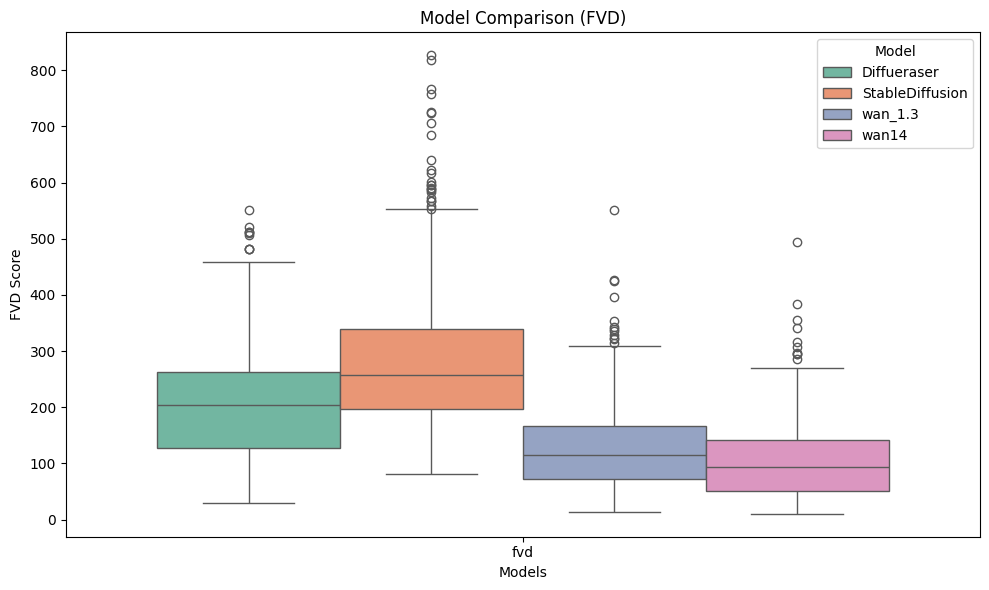

In [69]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=all_data_df[all_data_df["metric"] == "fvd"],
    x="metric",
    y="score",
    hue="model",
    palette="Set2"
)
plt.title("Model Comparison (FVD)")
plt.xlabel("Models")
plt.ylabel("FVD Score")
plt.legend(title="Model")
plt.tight_layout()
plt.show()
metric_to_show = "fvd"
subset = all_data_df[all_data_df["metric"] == metric_to_show]


C:\Users\Eric\AppData\Local\Temp\ipykernel_44068\2854198328.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(


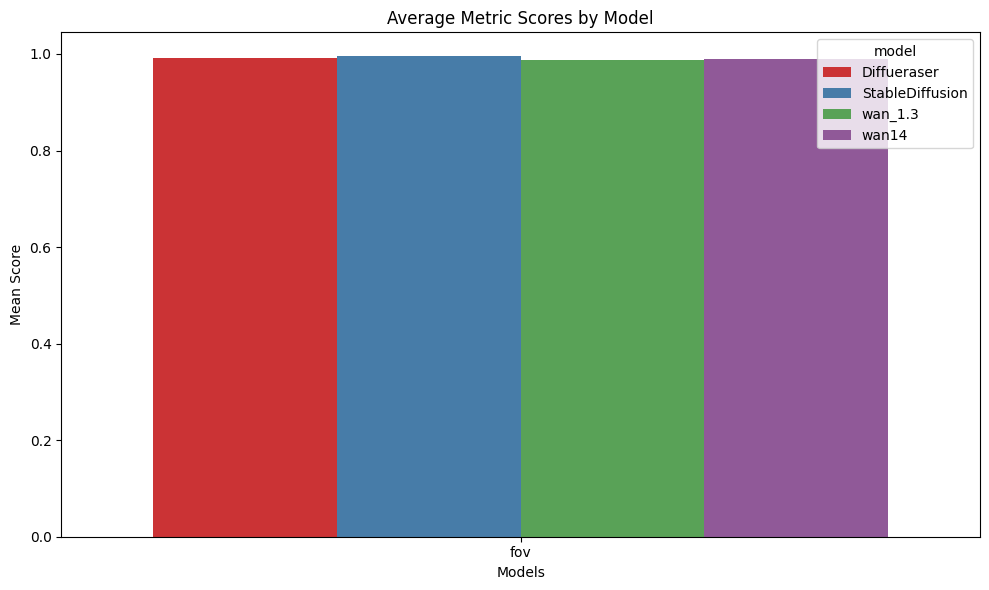

In [70]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data=summary_df[summary_df["metric"] == "fov"],  
    x="metric",
    y="mean",
    hue="model",
    palette="Set1",
    ci="sd"
)
plt.title("Average Metric Scores by Model")
plt.ylabel("Mean Score")
plt.xlabel("Models")
plt.tight_layout()
plt.show()

fov_means = summary_df[summary_df["metric"] == "fov"][["model", "mean", "std"]]


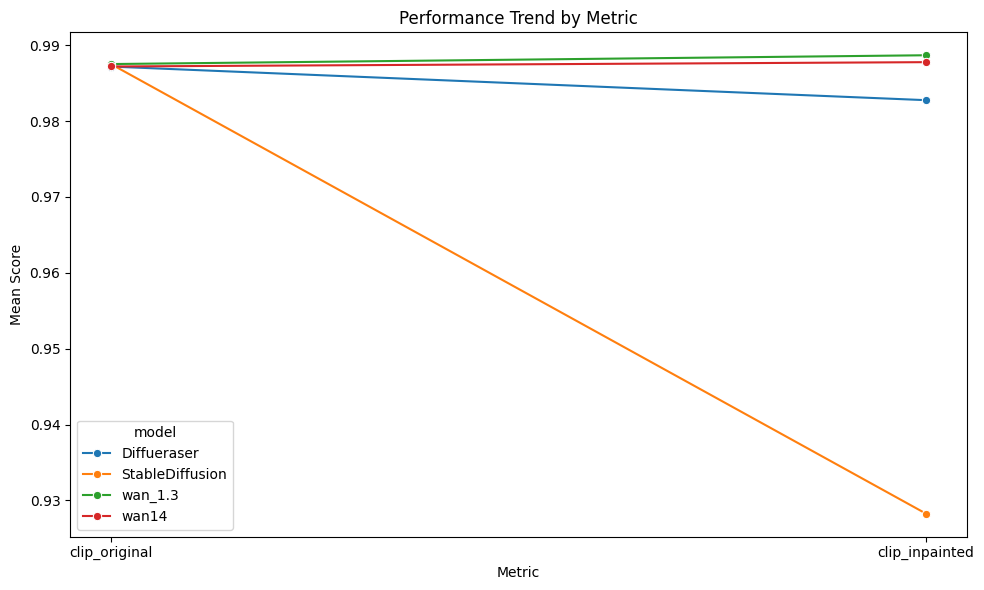

In [71]:
plt.figure(figsize=(10, 6))
summary_df2=summary_df[summary_df["metric"] != "fov"]
sns.lineplot(
    data=summary_df2[summary_df2["metric"] !="fvd"], 
    x="metric",
    y="mean",
    hue="model",
    marker="o"
)
plt.title("Performance Trend by Metric")
plt.ylabel("Mean Score")
plt.xlabel("Metric")
plt.tight_layout()
plt.show()
plot_data = summary_df2[summary_df2["metric"] != "fvd"]

